# 수치형 테이블 증강기

본 프로그램에서 사용하는 데이터 증강기는 수치형 테이블 데이터를 대상으로 함.

주요 기능
- 딥러닝 기반 Variational Autoencoder를 활용하여 수치형 학습데이터 내 클래스 불균형 문제를 해결하고, 주어진 테이블 데이터를 인위적으로 레코드 개수를 증강하여 학습모델의 성능을 향상



예시로, 레코드 수가 3276개인 water_potability.csv 수치형 데이터셋을 활용하였으며, 데이터 증강한 결과는 다음과 같다.

[원본 데이터셋]

Logistic Regression 
정확도 0.62 F1-score 0

Random Forest : 정확도 0.68 F1-score 0.45

XGBoost : 정확도 0.65 F1-score 0.46






[샘플 데이터셋(+100% 기준)]


Logistic Regression 
정확도 0.83 F1-score 0.90

Random Forest : 정확도 0.90 F1-score 0.93

XGBoost : 정확도 0.90 F1-score 0.94




수치형 테이블 증강기로 실험한 결과 Logistic Regression에서 정확도 21%, F1-score 90%,  Random Forest에서 정확도 : 22%, F1-score : 48%, XGBoost에서 정확도 25%, F1-score 48% 향상

# 패키지 다운로드

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (3,919 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
!pip install mlprep-ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import math
import random
import os
import time
from numpy import interp

import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split,cross_val_predict,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
from imblearn.pipeline import Pipeline as imbPipe
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

from collections import Counter
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import mlprepare as mlp

In [ ]:
# 시각화 스타일 적용

cust_palt = [
    '#111d5e', '#c70039', '#f37121', '#ffbd69', '#ffc93c'
]

plt.style.use('ggplot')

In [ ]:
#폰트 지정

plt.rc('font', family='NanumBarunGothic') 

# 데이터셋

In [ ]:
from google.colab import drive 

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
dir = '/content/gdrive/My Drive/Colab Notebooks/autoencoder_augmentation/D-VAE/data/'

df = pd.read_csv(dir+'water_potability.csv')

In [ ]:
#레이블 지정
label_name = 'Potability'

In [ ]:
#결측치 평균대치법 적용
df = df.fillna(df.mean())

In [ ]:
#학습에 필요없는 feature 삭제 및 레이블 인코딩
#df = df.drop(['Unnamed: 0'],axis=1)
#df = df.apply(LabelEncoder().fit_transform)

In [ ]:
len(df)

3276

In [ ]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [ ]:
X=df.drop(label_name,axis=1)
y=df[label_name]

In [ ]:
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658,1


# 원본 데이터 분류 모델 평가(정확도, F1-score)

In [ ]:
X_train,X_test, y_train, y_test =train_test_split(X,y,test_size=0.2, random_state=42) 

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

#LogisticRegression
log_reg_model = LogisticRegression(max_iter=1000, solver = "newton-cg")
log_reg_model.fit(X_train, y_train)
y_pred = log_reg_model.predict(X_test)
print("Model accuracy score: {}".format(accuracy_score(y_test, y_pred)))
print("Model F1-score score: {}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Model accuracy score: 0.6280487804878049
Model F1-score score: 0.0
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       412
           1       0.00      0.00      0.00       244

    accuracy                           0.63       656
   macro avg       0.31      0.50      0.39       656
weighted avg       0.39      0.63      0.48       656



In [ ]:
#RandomForest
random_forest_model = RandomForestClassifier(random_state = 0)
random_forest_model.fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)
print("Model accuracy score: {}".format(accuracy_score(y_test, y_pred)))
print("Model F1-score score: {}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Model accuracy score: 0.6844512195121951
Model F1-score score: 0.4509283819628647
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       412
           1       0.64      0.35      0.45       244

    accuracy                           0.68       656
   macro avg       0.67      0.62      0.61       656
weighted avg       0.67      0.68      0.66       656



In [ ]:
#XGBoost
model = xgb.XGBClassifier(n_estimators= 1000,objective= 'binary:logistic', seed=42)
model.fit(X_train, y_train)
y_pred= model.predict(X_test)
print("Model accuracy score: {}".format(accuracy_score(y_test, y_pred)))
print("Model F1-score score :{}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Model accuracy score: 0.6539634146341463
Model F1-score score :0.46335697399527187
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       412
           1       0.55      0.40      0.46       244

    accuracy                           0.65       656
   macro avg       0.62      0.60      0.60       656
weighted avg       0.64      0.65      0.64       656



In [ ]:
X

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075
...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821
3272,7.808856,193.553212,17329.802160,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243
3273,9.419510,175.762646,33155.578218,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875
3274,5.126763,230.603758,11983.869376,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658


In [ ]:
y

0       0
1       0
2       0
3       0
4       0
       ..
3271    1
3272    1
3273    1
3274    1
3275    1
Name: Potability, Length: 3276, dtype: int64

# 원본 데이터 시각화

Text(0.5, 1.0, 'Class Distribution \n 0: no || 1: yes)')

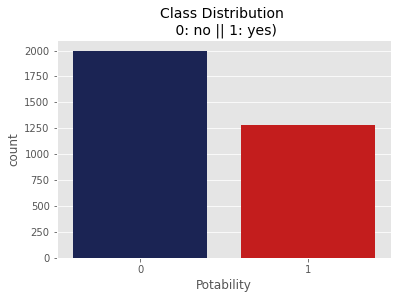

In [ ]:
#원본데이터 클래스 분포
colors = ["#111d5e", "#DF0101"]

sns.countplot(label_name, data=df, palette=colors)
plt.title('Class Distribution \n 0: no || 1: yes)', fontsize=14)

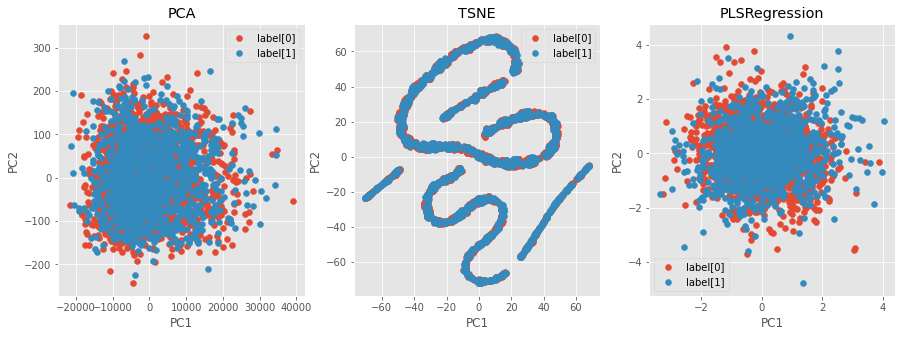

In [ ]:
#원본 데이터 차원 축소 후 시각화

fig, ax = plt.subplots(1,3,figsize=(15,5))

# PCA
points = PCA(n_components=2, random_state=2019).fit_transform(X)
ax[0].scatter(points[y==0,0], points[y==0,1], label="label[0]")
ax[0].scatter(points[y==1,0], points[y==1,1], label="label[1]")
ax[0].set_title("PCA")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[0].legend()

# TSNE
points = TSNE(n_components=2, random_state=2019).fit_transform(X)
ax[1].scatter(points[y==0,0], points[y==0,1], label="label[0]")
ax[1].scatter(points[y==1,0], points[y==1,1], label="label[1]")
ax[1].set_title("TSNE")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")
ax[1].legend()

# PLS
points, _ = PLSRegression(n_components=2).fit_transform(X,y)
ax[2].scatter(points[y==0,0], points[y==0,1], label="label[0]")
ax[2].scatter(points[y==1,0], points[y==1,1], label="label[1]")
ax[2].set_title("PLSRegression")
ax[2].set_xlabel("PC1")
ax[2].set_ylabel("PC2")
ax[2].legend()

plt.show()
plt.close()


# 레코드 증강

In [ ]:
#이산화 함수
def kbin_cat(col, X, nbins=5):
    
    ''' A function for binning multiple numeric columns'''
    
    categorize = KBinsDiscretizer(n_bins = nbins, encode = 'onehot', strategy = 'kmeans')
    cat = categorize.fit_transform(X[col].values.reshape(-1,1))
    cat= pd.DataFrame(cat.toarray())
    cat_n = [f'cat_{str(i)}' for i in range(nbins)]
    cat.columns = [i.replace('cat',f'{str(col)}') for i in cat_n]
    cat = cat.astype('int')
    
    return cat

In [ ]:
continuous = [i for i in df.loc[:,df.nunique()>=30]]

In [ ]:
#이산화 적용
rt = continuous
X_cat = X
for i in rt:    
  X_cat = X_cat.join(kbin_cat(i,X,5))
  X_cat.drop(i, axis=1, inplace=True)
X = X_cat

In [ ]:
continuous

['ph',
 'Hardness',
 'Solids',
 'Chloramines',
 'Sulfate',
 'Conductivity',
 'Organic_carbon',
 'Trihalomethanes',
 'Turbidity']

In [ ]:
df= pd.concat([X, y], axis = 1)

In [ ]:
X_train,X_test, y_train, y_test =train_test_split(X,y,test_size=0.2, random_state=42) 

In [ ]:
# RFECV 기법 적용
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 44
Best features : Index(['ph_0', 'ph_1', 'ph_2', 'ph_3', 'ph_4', 'Hardness_1', 'Hardness_2',
       'Hardness_3', 'Hardness_4', 'Solids_0', 'Solids_1', 'Solids_2',
       'Solids_3', 'Solids_4', 'Chloramines_0', 'Chloramines_1',
       'Chloramines_2', 'Chloramines_3', 'Chloramines_4', 'Sulfate_0',
       'Sulfate_1', 'Sulfate_2', 'Sulfate_3', 'Sulfate_4', 'Conductivity_0',
       'Conductivity_1', 'Conductivity_2', 'Conductivity_3', 'Conductivity_4',
       'Organic_carbon_0', 'Organic_carbon_1', 'Organic_carbon_2',
       'Organic_carbon_3', 'Organic_carbon_4', 'Trihalomethanes_0',
       'Trihalomethanes_1', 'Trihalomethanes_2', 'Trihalomethanes_3',
       'Trihalomethanes_4', 'Turbidity_0', 'Turbidity_1', 'Turbidity_2',
       'Turbidity_3', 'Turbidity_4'],
      dtype='object')


In [ ]:
X = df[X_train.columns[rfecv.support_]]

In [ ]:
X

,ph_0,ph_1,ph_2,ph_3,ph_4,Hardness_1,Hardness_2,Hardness_3,Hardness_4,Solids_0,...,Trihalomethanes_0,Trihalomethanes_1,Trihalomethanes_2,Trihalomethanes_3,Trihalomethanes_4,Turbidity_0,Turbidity_1,Turbidity_2,Turbidity_3,Turbidity_4
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3272,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3273,0,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3274,0,1,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
df= pd.concat([X, y], axis = 1)

In [ ]:
df

,ph_0,ph_1,ph_2,ph_3,ph_4,Hardness_1,Hardness_2,Hardness_3,Hardness_4,Solids_0,...,Trihalomethanes_1,Trihalomethanes_2,Trihalomethanes_3,Trihalomethanes_4,Turbidity_0,Turbidity_1,Turbidity_2,Turbidity_3,Turbidity_4,Potability
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
3272,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3273,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3274,0,1,0,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,1


In [ ]:
#전처리 완료된 데이터 저장
df.to_csv('/content/gdrive/My Drive/Colab Notebooks/autoencoder_augmentation/D-VAE/data/result/water_REFCV.csv')

In [ ]:
#변분오토인코더로 샘플 데이터 생성
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return loss_MSE + loss_KLD

class Autoencoder(nn.Module):
    def __init__(self,D_in=None,H=50,H2=12,latent_dim=3):

        if D_in==None:
            raise ValueError('You need to specify the Input shape.')
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
        # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class AutoencoderModel:
    def __init__(self,trainloader,testloader,device,D_in,H=50,H2=12,latent_dim=3):
        self.trainloader=trainloader
        self.testloader=testloader
        self.device=device
        self.D_in=D_in
        self.H=H
        self.H2=H2
        self.latent_dim=latent_dim
        self.model=Autoencoder(D_in, H, H2).to(self.device)
        self.optimizer=optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_mse = customLoss()
    
    def train_model(self,epoch, verbose, interval):
        train_losses = []
        self.model.train()
        train_loss = 0
        for _, data in enumerate(self.trainloader):
            data = data.to(self.device)
            self.optimizer.zero_grad()
            recon_batch, mu, logvar = self.model(data)
            loss = self.loss_mse(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()
        if verbose:
            if epoch % interval == 0:        
                print('====> Epoch: {} Average training loss: {:.4f}'.format(
                    epoch, train_loss / len(self.trainloader.dataset)))
                train_losses.append(train_loss / len(self.trainloader.dataset))

    def test_model(self, epoch, verbose, interval):
        test_losses = []
        with torch.no_grad():
            test_loss = 0
            for _, data in enumerate(self.testloader):
                data = data.to(self.device)
                self.optimizer.zero_grad()
                recon_batch, mu, logvar = self.model(data)
                loss = self.loss_mse(recon_batch, data, mu, logvar)
                test_loss += loss.item()
            if verbose:
                if epoch % interval == 0:        
                    print('====> Epoch: {} Average test loss: {:.4f}'.format(
                        epoch, test_loss / len(self.testloader.dataset)))
                test_losses.append(test_loss / len(self.testloader.dataset))

    def fit(self, epochs, verbose=True, interval=200):
        for epoch in range(1, epochs + 1):
            self.train_model(epoch, verbose, interval)
            self.test_model(epoch, verbose, interval)
        return self

    def predict(self, no_samples, target_class):
        with torch.no_grad():
            for batch_idx, data in enumerate(self.trainloader):
                data = data.to(self.device)
                self.optimizer.zero_grad()
                _, mu_, logvar_ = self.model(data)
                if batch_idx==0:
                    mu=mu_
                    logvar=logvar_
                else:
                    mu=torch.cat((mu, mu_), dim=0)
                    logvar=torch.cat((logvar, logvar_), dim=0)
        sigma = torch.exp(logvar/2)
        no_samples = no_samples
        q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
        z = q.rsample(sample_shape=torch.Size([no_samples]))
        with torch.no_grad():
            pred = self.model.decode(z).cpu().numpy()
        df_fake = pd.DataFrame(pred)
        df_fake[label_name]=target_class
        return df_fake

In [ ]:
y.value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

In [ ]:
dir = '/content/gdrive/My Drive/Colab Notebooks/autoencoder_augmentation/D-VAE/data/result'

df = pd.read_csv(dir+'/water_REFCV.csv')
df = df.drop(['Unnamed: 0'],axis=1)

In [ ]:
df

,ph_0,ph_1,ph_2,ph_3,ph_4,Hardness_1,Hardness_2,Hardness_3,Hardness_4,Solids_0,...,Trihalomethanes_1,Trihalomethanes_2,Trihalomethanes_3,Trihalomethanes_4,Turbidity_0,Turbidity_1,Turbidity_2,Turbidity_3,Turbidity_4,Potability
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
3272,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3273,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3274,0,1,0,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,1


In [ ]:
#훈련데이터, 테스트데이터 분리
X_train, X_test, y_train, y_test = mlp.split_df(df, dep_var=label_name, test_size=0.3, split_mode='random')
X_train_fraud = X_train.iloc[np.where(y_train==1)[0]]
X_test_fraud = X_test.iloc[np.where(y_test==1)[0]]

In [ ]:
#오버샘플링 및 랜덤포레스트
def rf(xs, y, n_estimators=40, max_samples=398,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True,  class_weight={0:1,1:543}).fit(xs, y)

In [ ]:
m = rf(X_train, y_train)

In [ ]:
confusion_matrix(y_test, np.round(m.predict(X_test)))

array([[  2, 593],
       [  1, 387]])

### 변분 오토인코더를 활용한 데이터 증강

In [ ]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, dataset):
        self.x = dataset.values
        self.x = torch.from_numpy(self.x).to(torch.float)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

traindata_set=DataBuilder(X_train_fraud)
testdata_set=DataBuilder(X_test_fraud)

trainloader=DataLoader(dataset=traindata_set,batch_size=1024)
testloader=DataLoader(dataset=testdata_set,batch_size=1024)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D_in = traindata_set.x.shape[1]
H = 50
H2 = 12
autoenc_model = AutoencoderModel(trainloader, testloader, device, D_in, H, H2, latent_dim=3)

In [ ]:
len(df)

3276

### 모델 학습

In [ ]:
start_time = time.time()
print("Start")

autoenc_model_fit = autoenc_model.fit(2000)


print("End")
print("Time: {:.4f}sec".format((time.time() - start_time)))

Start
====> Epoch: 200 Average training loss: 31.4026
====> Epoch: 200 Average test loss: 32.8549
====> Epoch: 400 Average training loss: 20.9175
====> Epoch: 400 Average test loss: 22.6936
====> Epoch: 600 Average training loss: 14.7997
====> Epoch: 600 Average test loss: 16.3553
====> Epoch: 800 Average training loss: 11.1572
====> Epoch: 800 Average test loss: 12.8084
====> Epoch: 1000 Average training loss: 9.1317
====> Epoch: 1000 Average test loss: 10.2570
====> Epoch: 1200 Average training loss: 8.0638
====> Epoch: 1200 Average test loss: 8.9171
====> Epoch: 1400 Average training loss: 7.5623
====> Epoch: 1400 Average test loss: 8.1270
====> Epoch: 1600 Average training loss: 7.2426
====> Epoch: 1600 Average test loss: 7.5651
====> Epoch: 1800 Average training loss: 6.9959
====> Epoch: 1800 Average test loss: 7.1549
====> Epoch: 2000 Average training loss: 6.8407
====> Epoch: 2000 Average test loss: 6.9659
End
Time: 29.3111sec


In [ ]:
y_train.value_counts()

0    1403
1     890
Name: Potability, dtype: int64

# 증강할 레코드 비율 설정

In [ ]:
#no_samples에는 증강할 레코드 수 지정
df_fake = autoenc_model_fit.predict(no_samples=5896,target_class=1)

In [ ]:
df_fake.columns = df.columns
df_fake[label_name] = np.round(df_fake[label_name]).astype(int)
df_fake.head()

,ph_0,ph_1,ph_2,ph_3,ph_4,Hardness_1,Hardness_2,Hardness_3,Hardness_4,Solids_0,...,Trihalomethanes_1,Trihalomethanes_2,Trihalomethanes_3,Trihalomethanes_4,Turbidity_0,Turbidity_1,Turbidity_2,Turbidity_3,Turbidity_4,Potability
0,0.111686,0.053888,0.659980,0.167573,0.004288,0.552935,0.215115,0.106717,0.011998,0.044661,...,0.074150,0.618397,0.182607,0.006067,0.020842,0.176163,0.172548,0.365841,0.219569,1
1,0.048601,0.260206,0.438302,0.164012,0.081280,0.150163,0.307135,0.395232,0.073612,0.235314,...,0.220979,0.334309,0.279731,0.083696,0.117552,0.209323,0.319047,0.173908,0.200596,1
2,0.153945,0.085194,0.647069,0.142332,-0.032330,0.459440,0.099022,0.164405,0.062581,0.119191,...,0.039654,0.765689,-0.005409,0.074205,0.015914,0.586515,0.141658,0.112038,0.180212,1
3,0.086396,0.177817,0.487513,0.180485,0.074235,0.181380,0.315448,0.361704,0.040803,0.172733,...,0.186477,0.423857,0.221922,0.069738,0.088651,0.276190,0.272653,0.208832,0.167474,1
4,0.036917,0.238498,0.367349,0.276955,0.099364,0.150266,0.391570,0.281987,0.137380,0.197332,...,0.244026,0.276704,0.289654,0.139382,0.116139,0.182428,0.321700,0.268620,0.105114,1


In [ ]:
len(df_fake)

5896

In [ ]:
#샘플 데이터(원본 데이터+샘플 데이터)
X_train_augmented = X_train.append(df_fake.drop([label_name],axis=1))
X_train_augmented.head()

,ph_0,ph_1,ph_2,ph_3,ph_4,Hardness_1,Hardness_2,Hardness_3,Hardness_4,Solids_0,...,Trihalomethanes_0,Trihalomethanes_1,Trihalomethanes_2,Trihalomethanes_3,Trihalomethanes_4,Turbidity_0,Turbidity_1,Turbidity_2,Turbidity_3,Turbidity_4
2876,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2156,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
765,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1819,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
244,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
y_train_augmented = y_train.append(df_fake[label_name])
y_train_augmented.head()

2876    0
2156    0
765     1
1819    0
244     0
Name: Potability, dtype: int64

In [ ]:
def rf_aug(xs, y, n_estimators=40, max_samples=500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m_aug = rf_aug(X_train_augmented, y_train_augmented)
confusion_matrix(y_test, np.round(m_aug.predict(X_test)))

array([[555,  40],
       [351,  37]])

In [ ]:
m_aug

RandomForestClassifier(max_features=0.5, max_samples=500, min_samples_leaf=5,
                       n_estimators=40, n_jobs=-1, oob_score=True)

In [ ]:
X_train,X_test, y_train, y_test =train_test_split(X_train_augmented,y_train_augmented,test_size=0.2, random_state=42) 

In [ ]:
df_sample= pd.concat([X_train_augmented, y_train_augmented], axis = 1)

In [ ]:
#샘플 데이터 저장
df_sample.to_csv('/content/gdrive/My Drive/Colab Notebooks/autoencoder_augmentation/D-VAE/data/result/water_80%.csv')

# 샘플 데이터 시각화

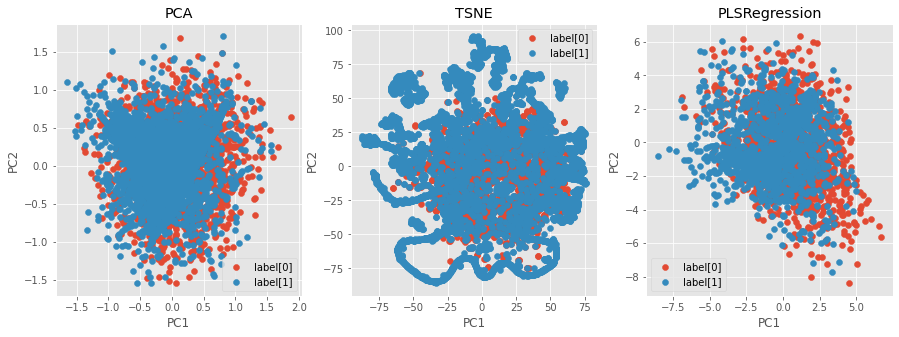

In [ ]:
#샘플 데이터 차원 축소 시각화
fig, ax = plt.subplots(1,3,figsize=(15,5))

# PCA
points = PCA(n_components=2, random_state=2019).fit_transform(X_train_augmented)
ax[0].scatter(points[y_train_augmented==0,0], points[y_train_augmented==0,1], label="label[0]")
ax[0].scatter(points[y_train_augmented==1,0], points[y_train_augmented==1,1], label="label[1]")
ax[0].set_title("PCA")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[0].legend()

# TSNE
points = TSNE(n_components=2, random_state=2019).fit_transform(X_train_augmented)
ax[1].scatter(points[y_train_augmented==0,0], points[y_train_augmented==0,1], label="label[0]")
ax[1].scatter(points[y_train_augmented==1,0], points[y_train_augmented==1,1], label="label[1]")
ax[1].set_title("TSNE")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")
ax[1].legend()

# PLS
points, _ = PLSRegression(n_components=2).fit_transform(X_train_augmented,y_train_augmented)
ax[2].scatter(points[y_train_augmented==0,0], points[y_train_augmented==0,1], label="label[0]")
ax[2].scatter(points[y_train_augmented==1,0], points[y_train_augmented==1,1], label="label[1]")
ax[2].set_title("PLSRegression")
ax[2].set_xlabel("PC1")
ax[2].set_ylabel("PC2")
ax[2].legend()

plt.show()
plt.close()


Text(0.5, 1.0, 'Class Distribution \n (0: no || 1: yes)')

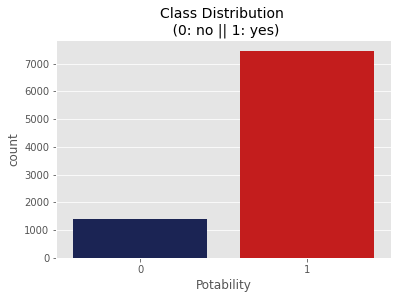

In [ ]:
#샘플 데이터 클래스 분포

colors = ["#111d5e", "#DF0101"]

sns.countplot(label_name, data=df_sample, palette=colors)
plt.title('Class Distribution \n (0: no || 1: yes)', fontsize=14)

# 샘플 데이터 분류 모델 평가(정확도, F1-score)

In [ ]:
X_train,X_test, y_train, y_test =train_test_split(X_train_augmented,y_train_augmented,test_size=0.2, random_state=42) 

In [ ]:
#LogisticRegression
log_reg_model = LogisticRegression(max_iter=1000, solver = "newton-cg")
log_reg_model.fit(X_train, y_train)
y_pred = log_reg_model.predict(X_test)
print("Model accuracy score: {}".format(accuracy_score(y_test, y_pred)))
print("Model F1-score score: {}".format(f1_score(y_test, y_pred)))

Model accuracy score: 0.8360655737704918
Model F1-score score: 0.9098258706467661


In [ ]:
#RandomForest
random_forest_model = RandomForestClassifier(random_state = 0)
random_forest_model.fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)
print("Model accuracy score: {}".format(accuracy_score(y_test, y_pred)))
print("Model F1-score score: {}".format(f1_score(y_test, y_pred)))

Model accuracy score: 0.8982475975127191
Model F1-score score: 0.9371508379888268


In [ ]:
#XGBoost
model = xgb.XGBClassifier(n_estimators= 1000,objective= 'binary:logistic', seed=42)
model.fit(X_train, y_train)
y_pred= model.predict(X_test)
print("Model accuracy score: {}".format(accuracy_score(y_test, y_pred)))
print("Model F1-score score :{}".format(f1_score(y_test, y_pred)))

Model accuracy score: 0.8988128886376484
Model F1-score score :0.9385934819897085
